In [0]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.filters import threshold_otsu
import numpy as np
from glob import glob
from scipy import misc
from matplotlib.patches import Circle,Ellipse
from matplotlib.patches import Rectangle
import os
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [6]:
!git clone https://github.com/pranayanand123/Denoiding-AutoEncoder-Keras.git

Cloning into 'Denoiding-AutoEncoder-Keras'...
remote: Counting objects: 338, done.
remote: Compressing objects: 100% (308/308), done.
remote: Total 338 (delta 29), reused 337 (delta 28), pack-reused 0
Receiving objects: 100% (338/338), 25.88 MiB | 8.05 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [22]:
!ls Denoiding-AutoEncoder-Keras/data/DB1_B

101_1.tif  102_5.tif  104_1.tif  105_5.tif  107_1.tif  108_5.tif  110_1.tif
101_2.tif  102_6.tif  104_2.tif  105_6.tif  107_2.tif  108_6.tif  110_2.tif
101_3.tif  102_7.tif  104_3.tif  105_7.tif  107_3.tif  108_7.tif  110_3.tif
101_4.tif  102_8.tif  104_4.tif  105_8.tif  107_4.tif  108_8.tif  110_4.tif
101_5.tif  103_1.tif  104_5.tif  106_1.tif  107_5.tif  109_1.tif  110_5.tif
101_6.tif  103_2.tif  104_6.tif  106_2.tif  107_6.tif  109_2.tif  110_6.tif
101_7.tif  103_3.tif  104_7.tif  106_3.tif  107_7.tif  109_3.tif  110_7.tif
101_8.tif  103_4.tif  104_8.tif  106_4.tif  107_8.tif  109_4.tif  110_8.tif
102_1.tif  103_5.tif  105_1.tif  106_5.tif  108_1.tif  109_5.tif
102_2.tif  103_6.tif  105_2.tif  106_6.tif  108_2.tif  109_6.tif
102_3.tif  103_7.tif  105_3.tif  106_7.tif  108_3.tif  109_7.tif
102_4.tif  103_8.tif  105_4.tif  106_8.tif  108_4.tif  109_8.tif


In [0]:
data = glob('Denoiding-AutoEncoder-Keras/data/DB*/*')

In [27]:
len(data)

320

In [28]:
data[:2]

['Denoiding-AutoEncoder-Keras/data/DB4_B/105_7.tif',
 'Denoiding-AutoEncoder-Keras/data/DB4_B/109_8.tif']

In [0]:
images = []
def read_images(data):
    for i in range(len(data)):
        img = misc.imread(data[i])
        img = misc.imresize(img,(224,224))
        images.append(img)
    return images

In [30]:
images = read_images(data)

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [31]:
images[0].shape

(224, 224)

In [32]:
images[0].dtype

dtype('uint8')

In [33]:
images_arr = np.asarray(images)
images_arr = images_arr.astype('float32')
images_arr[0].dtype

dtype('float32')

In [34]:
images_arr.shape

(320, 224, 224)

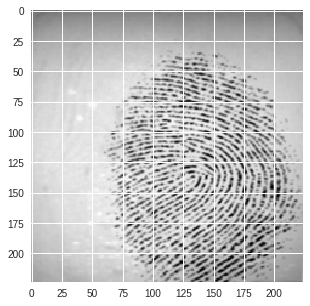

In [35]:
plt.figure(figsize=[5, 5])
curr_img = images_arr[3]
plt.imshow(curr_img, cmap='gray')
plt.show()

In [0]:
images_arr = images_arr.reshape(-1, 224,224, 1)

In [37]:
images_arr.shape

(320, 224, 224, 1)

In [38]:
images_arr[0]

array([[[ 80.],
        [ 81.],
        [ 81.],
        ...,
        [ 77.],
        [ 75.],
        [ 75.]],

       [[ 82.],
        [ 83.],
        [ 83.],
        ...,
        [ 79.],
        [ 77.],
        [ 77.]],

       [[ 84.],
        [ 85.],
        [ 85.],
        ...,
        [ 80.],
        [ 79.],
        [ 79.]],

       ...,

       [[138.],
        [136.],
        [137.],
        ...,
        [128.],
        [130.],
        [148.]],

       [[137.],
        [133.],
        [135.],
        ...,
        [122.],
        [126.],
        [148.]],

       [[135.],
        [133.],
        [133.],
        ...,
        [112.],
        [116.],
        [139.]]], dtype=float32)

In [39]:
images_arr = images_arr / np.max(images_arr)
images_arr[0]

array([[[0.3137255 ],
        [0.31764707],
        [0.31764707],
        ...,
        [0.3019608 ],
        [0.29411766],
        [0.29411766]],

       [[0.32156864],
        [0.3254902 ],
        [0.3254902 ],
        ...,
        [0.30980393],
        [0.3019608 ],
        [0.3019608 ]],

       [[0.32941177],
        [0.33333334],
        [0.33333334],
        ...,
        [0.3137255 ],
        [0.30980393],
        [0.30980393]],

       ...,

       [[0.5411765 ],
        [0.53333336],
        [0.5372549 ],
        ...,
        [0.5019608 ],
        [0.50980395],
        [0.5803922 ]],

       [[0.5372549 ],
        [0.52156866],
        [0.5294118 ],
        ...,
        [0.47843137],
        [0.49411765],
        [0.5803922 ]],

       [[0.5294118 ],
        [0.52156866],
        [0.52156866],
        ...,
        [0.4392157 ],
        [0.45490196],
        [0.54509807]]], dtype=float32)

In [0]:
train_X,valid_X,train_ground,valid_ground = train_test_split(images_arr,
                                                             images_arr,
                                                             test_size=0.2,
                                                             random_state=1)

In [0]:
batch_size = 8
epochs = 50
Channel = 1
x, y = 224, 224
input_img = Input(shape = (x, y, Channel))

In [0]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [0]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [44]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 128)       147584    
__________

In [45]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Train on 256 samples, validate on 64 samples
Epoch 1/50
256/256 [==============================] - 6s 24ms/step - loss: 0.0496 - val_loss: 0.0259
Epoch 2/50
256/256 [==============================] - 4s 14ms/step - loss: 0.0248 - val_loss: 0.0140
Epoch 3/50
256/256 [==============================] - 4s 14ms/step - loss: 0.0193 - val_loss: 0.0158
Epoch 4/50
256/256 [==============================] - 4s 14ms/step - loss: 0.0181 - val_loss: 0.0137
Epoch 5/50
256/256 [==============================] - 4s 14ms/step - loss: 0.0166 - val_loss: 0.0152
Epoch 6/50
256/256 [==============================] - 4s 14ms/step - loss: 0.0152 - val_loss: 0.0106
Epoch 7/50
256/256 [==============================] - 4s 14ms/step - loss: 0.0161 - val_loss: 0.0108
Epoch 8/50
256/256 [==============================] - 4s 14ms/step - loss: 0.0131 - val_loss: 0.0123
Epoch 9/50
256/256 [==============================] - 4s 14ms/step - loss: 0.0123 - val_loss: 0.0286
Epoch 10/50
256/256 [=========================

In [0]:
pred = autoencoder.predict(valid_X)

In [51]:
pred[0].shape

(224, 224, 1)

Test Images


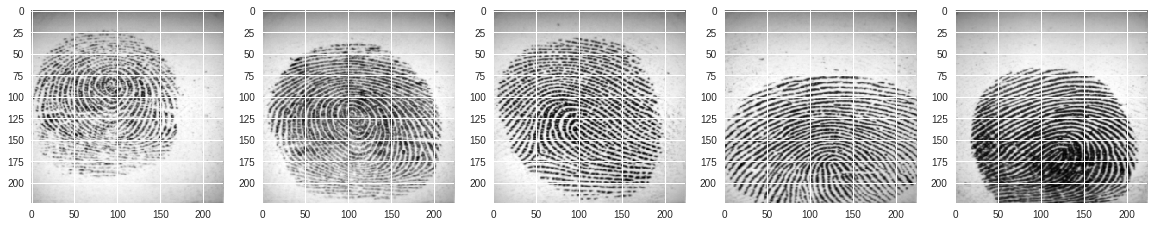

Reconstruction of Test Images


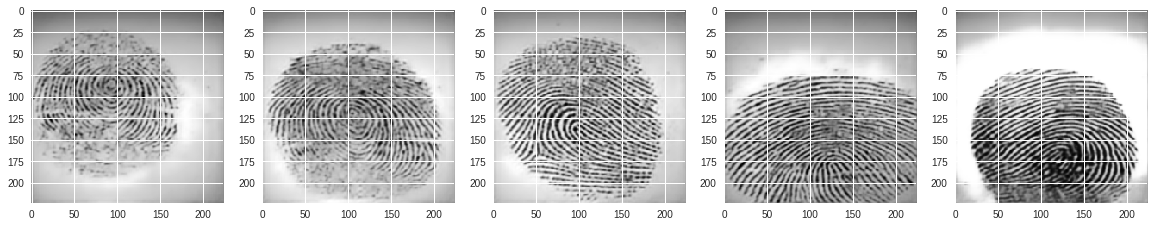

In [49]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(valid_ground[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()